In [1]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
#import gensim.utils.lemmatize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the data using Pandas
data = pd.read_csv('globe_data/bostonglobe2014.csv')

In [3]:
# strip the text of unnecessary whitespaces and removing special characters
def custom_standardization(data):

    spec_chars = ["!",'"',"#","%","&","'","(",")", "*","+",",",
                  "-",".","/",":",";","<", "=",">","?","@","[",
                  "\\","]","^","_", "`","{","|","}","~","–", 
                  "\xc2", "\xa0", "\x80", "\x9c", "\x99", "\x94", 
                  "\xad", "\xe2", "\x9d", "\n"]

    for char in spec_chars:
        data['text'] = data['text'].str.strip()
        data['text'] = data['text'].str.replace(char, ' ')
        
    return data

# do stemming before training
# compare differences between word vectors for 'black' as well as 'white' to better identify biased representations
# think about word frequency, so that context isn't specific, but rather, general
# increase data point size for visualizations

# instead of keywords, use sub-neighborhood names

# cluster similar words
# visualize those with a meta word that's representative
# either use average word vectors or minimizing function to get representative word

In [4]:
df = custom_standardization(data)

In [5]:
# turn DataFrame into a list of lists of tokens
documents = []
for row in df.values:
    [row] = row
    temp = row.lower().split()
    length = len(temp) - 1
    for i in range(length):
        if temp[i] == 'hyde' and temp[i + 1] == 'park':
            temp[i] = 'hyde_park'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'beacon' and temp[i + 1] == 'hill':
            temp[i] = 'beacon_hill'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'south' and temp[i + 1] == 'boston':
            temp[i] = 'south_boston'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'jamaica' and temp[i + 1] == 'plain':
            temp[i] = 'jamaica_plain'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'east' and temp[i + 1] == 'boston':
            temp[i] = 'east_boston'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'south' and temp[i + 1] == 'end':
            temp[i] = 'south_end'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'back' and temp[i + 1] == 'bay':
            temp[i] = 'back_bay'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'north' and temp[i + 1] == 'end':
            temp[i] = 'north_end'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'west' and temp[i + 1] == 'roxbury':
            temp[i] = 'west_roxbury'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'mission' and temp[i + 1] == 'hill':
            temp[i] = 'mission_hill'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'harbor' and temp[i + 1] == 'islands':
            temp[i] = 'harbor_islands'
            temp.pop(i + 1)
            length -= 1
        elif temp[i] == 'west' and temp[i + 1] == 'end':
            temp[i] = 'west_end'
            temp.pop(i + 1)
            length -= 1
        elif i > 0 and temp[i - 1] == 'south' and temp[i] == 'boston' and temp[i + 1] == 'waterfront':
            temp[i - 1] = 'south_boston_waterfront'
            temp.pop(i + 1)
            temp.pop(i)
            length -= 2
        elif i > 0 and temp[i - 1] == 'longwood' and temp[i] == 'medical' and temp[i + 1] == 'area':
            temp[i - 1] = 'longwood_medical_area'
            temp.pop(i + 1)
            temp.pop(i)
            length -= 1
        elif i >= length - 3:
            break
    documents.append(temp)
    #print(len(documents))

In [6]:
# create Word2Vec model
# the skip-grams method is used here, with a window of 10
model = gensim.models.Word2Vec(window=10, min_count=2, sg=1, workers=10)
model.build_vocab(documents)  # prepare the model vocabulary

In [7]:
# train model on available data
# I use 5 epochs since that's standard
model.train(corpus_iterable=documents, total_examples=len(documents), epochs=5)

(7127559, 9143345)

In [8]:
# words of interest
# some words are missing in the final 'keywords' list since those do not occur in any of the articles

#black_keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 
#                  'neighborhood', 'child', 'children', 'kid', 'youth', 'business', 'company']

#black_ethnicities = ['black', 'cape verdean', 'afro latino', 'afro latina', 'haitian', 'african american', 
#                     'african-american', 'caribbean', 'jamaican', 'dominican', 'west indian']

black_neighborhoods = ['dorchester', 'roxbury', 'mattapan', 'hyde_park']
white_neighborhoods = ['fenway', 'beacon_hill', 'downtown', 'south_boston', 'east_boston', 'back_bay', 'jamaica_plain',
                      'south_end', 'charlestown', 'brighton', 'allston', 'west_end', 'roslindale', 'north_end',
                      'mission_hill', 
                       #'south_boston_waterfront', 
                       'harbor_islands', 'longwood_medical_area']

keywords = black_neighborhoods + white_neighborhoods

In [9]:
# finding similar words and creating a csv file
# code shamelessly copied from Hong

def compute_similar_words(model,source_word, topn=5):
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word, topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words    

def compute_similar_words_for_all_tasks(model, topn=5):
    columns = ['word' + str(i - 1) for i in range(1, topn + 2)]
    df = pd.DataFrame(data=None, columns=columns)
    for source_word in keywords:
        similar_words = compute_similar_words(model, source_word, topn)
        df.loc[len(df)] = similar_words
    for i in range(1, len(similar_words)):
        sec_similar_words = compute_similar_words(model, similar_words[i], topn)
        df.loc[len(df)] = sec_similar_words
    df.to_csv('similar_words_task/ngram_neigborhood_similar_words_task_2014.csv')

words = compute_similar_words_for_all_tasks(model)

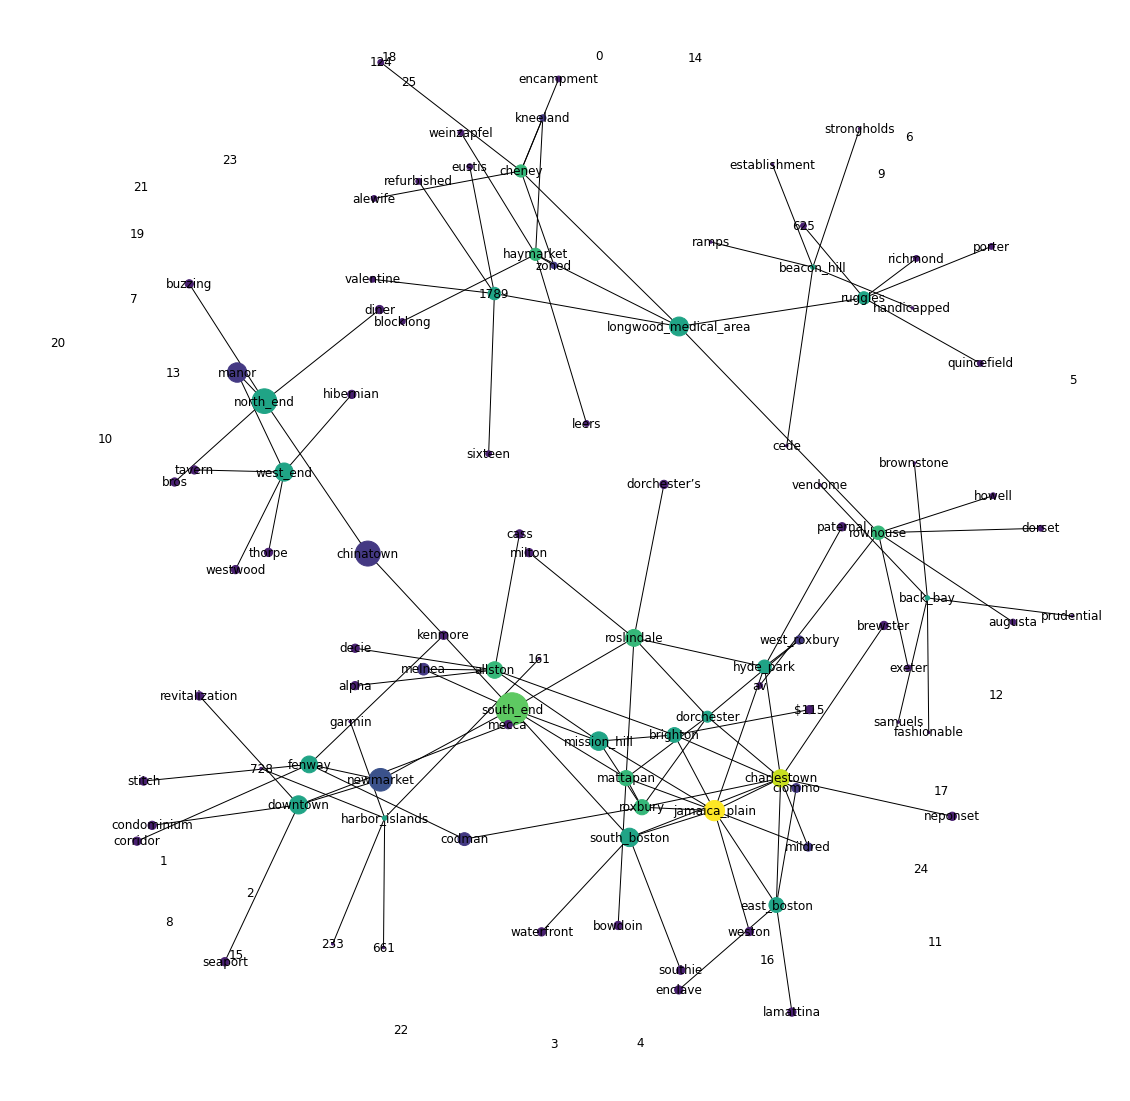

In [10]:
# create word cloud from csv file created using Word2Vec
# code shamelessly copied from Hong

import networkx as nx
from random import randint 
from itertools import count

words = pd.read_csv('similar_words_task/ngram_neigborhood_similar_words_task_2014.csv')

G = nx.Graph()
j = 1
for i, row in words.iterrows():
    for j in range(1, len(row)):
        G.add_node(i, label=row[j])
    for j in range(1, len(row)):
        G.add_edge(row[1], row[j])
remove = [node for node, degree in dict(G.degree()).items() if degree > 2]

pos = nx.spring_layout(G, k=0.3)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20, 20))
nx.draw_networkx(G, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size)
plt.axis('off')
plt.savefig('word_clouds_img/ngram_neigborhood_word_cloud_2014.png')
plt.show()